# Hurricane Season Analysis

## Data Gathering

### Pseudocode
1.  import dependencies
2.  get csv file
3.  read csv file into pandas
4.  display
5.  cleanup/delete unnecessary columns

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import csv
import matplotlib.pyplot as plt
import numpy as np
file = "hurricane_data.csv"

In [2]:
# Add headerrow containing storm id and storm name to data rows and create list
hurricane_data = []

storm_id = "0000000"
storm_name = "UNNAMED"
with open(file) as hurricane_file:
    hurricane_reader = csv.reader(hurricane_file)
    next(hurricane_reader, None) 
    for row in hurricane_reader:
                if 'AL' in row[0]: 
                    storm_id = row[0].strip()
                    storm_name = row[1].strip()
#                     print(f'{storm_id}: {storm_name}')
                else:
                    oldformat = row[0]+row[1]
                    datetimeobject = datetime.strptime(oldformat,'%Y%m%d %H%M%S')
                    date = datetimeobject.strftime('%m-%d-%Y %H%M%S')
                    year = row[0][:4]
                    landfall = row[2].strip()
                    status = row[3].strip()
                    latitude = row[4].strip()
                    longitude = row[5].strip()
                    wind = row[6].strip()
                    pressure = row[7].strip()
                hurricane_data.append(
                    {
                        "Storm_Id": storm_id, 
                        "Name": storm_name,
                        "Date": date,
                        "Year": year,
                        "Landfall": landfall,
                        "Status" : status,
                        "Latitude" : latitude,
                        "Longitude" : longitude,
                        "Windspeed" : wind,
                        "Pressure" : pressure
                    }
                ) 

In [3]:
# Create Dataframe and reorder columns
hurricane_pd = pd.DataFrame(hurricane_data)
hurricane_pd = hurricane_pd.loc[:, ["Storm_Id", "Name", "Date", "Year", "Status", "Latitude",
                                    "Longitude", "Windspeed", "Pressure", "Landfall"]]
hurricane_pd.head()

,Storm_Id,Name,Date,Year,Status,Latitude,Longitude,Windspeed,Pressure,Landfall
0,0000000,UNNAMED,06-25-1851 000000,1851,HU,28.0N,94.8W,80,-999,
1,0000000,UNNAMED,06-25-1851 060000,1851,HU,28.0N,95.4W,80,-999,
2,0000000,UNNAMED,06-25-1851 120000,1851,HU,28.0N,96.0W,80,-999,
3,0000000,UNNAMED,06-25-1851 180000,1851,HU,28.1N,96.5W,80,-999,
4,0000000,UNNAMED,06-25-1851 210000,1851,HU,28.2N,96.8W,80,-999,L


# Data Cleanup

### Pseudocode
1. Check column counts for missing data
2. Check/Change column types for type conversion
3. Limit data to only the past 15 years, only Hurricanes and Tropical Storms, and only named storms
4. Get min date (when storm became Tropical Storm) and Max Date (When storm is no longer a tropical storm)
5. Calculate the duration of storm
6. Find nearest city for storms tha reached landfall
7. Get max windspeed row and return all columns
8. Categorize storms according to Saffir-Simpson scale https://en.wikipedia.org/wiki/Maximum_sustained_wind 

In [4]:
#Check column counts for missing data
hurricane_pd.count()

Storm_Id     52150
Name         52150
Date         52150
Year         52150
Status       52150
Latitude     52150
Longitude    52150
Windspeed    52150
Pressure     52150
Landfall     52150
dtype: int64

In [5]:
#Check column types for needed type conversions
hurricane_pd.dtypes

Storm_Id     object
Name         object
Date         object
Year         object
Status       object
Latitude     object
Longitude    object
Windspeed    object
Pressure     object
Landfall     object
dtype: object

In [6]:
#Change types for Windspeed and Pressure to numerice and Date to Datetime
hurricane_pd['Windspeed'] = pd.to_numeric(hurricane_pd['Windspeed'])
hurricane_pd['Pressure'] = pd.to_numeric(hurricane_pd['Pressure'])
hurricane_pd['Date'] = pd.to_datetime(hurricane_pd['Date'])

In [7]:
# Limit data to only the past 15 years, 
# Only Hurricanes and Tropical Storms, and 
# Only named storms

hurricane_df_clean = hurricane_pd.loc[hurricane_pd["Year"] >= "1982"]
hurricane_df_clean = hurricane_df_clean.loc[hurricane_df_clean['Status'].isin(['TS','HU'])]
hurricane_df_clean = hurricane_df_clean.loc[hurricane_df_clean['Name'] != "UNNAMED"]
hurricane_df_clean.head()

,Storm_Id,Name,Date,Year,Status,Latitude,Longitude,Windspeed,Pressure,Landfall
35894,AL011982,ALBERTO,1982-06-03 06:00:00,1982,TS,22.8N,85.0W,40,1001,
35895,AL011982,ALBERTO,1982-06-03 12:00:00,1982,TS,23.2N,84.2W,50,995,
35896,AL011982,ALBERTO,1982-06-03 18:00:00,1982,HU,24.0N,83.6W,75,985,
35897,AL011982,ALBERTO,1982-06-04 00:00:00,1982,HU,24.8N,83.4W,65,992,
35898,AL011982,ALBERTO,1982-06-04 06:00:00,1982,TS,24.9N,84.1W,55,998,


In [8]:
# Get min date (when storm became Tropical Storm) and Max Date (When storm is no longer a tropical storm)
# Calculate the duration

storm_gb = hurricane_df_clean.groupby('Storm_Id')
storm_sgb = storm_gb['Date']
start_date = storm_sgb.min()
end_date = storm_sgb.max()
duration = end_date - start_date

In [9]:
#Merge Start Date, End Date, and Duration to original dataframe. 
start_end_df = pd.DataFrame({"Start Date": start_date
                             ,"End Date": end_date
                             ,"Duration" : duration
                            }).reset_index()

merge_df = pd.merge(hurricane_df_clean, start_end_df, how="outer", on="Storm_Id")

merge_df.head(100)


,Storm_Id,Name,Date,Year,Status,Latitude,Longitude,Windspeed,Pressure,Landfall,Duration,End Date,Start Date
0,AL011982,ALBERTO,1982-06-03 06:00:00,1982,TS,22.8N,85.0W,40,1001,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
1,AL011982,ALBERTO,1982-06-03 12:00:00,1982,TS,23.2N,84.2W,50,995,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
2,AL011982,ALBERTO,1982-06-03 18:00:00,1982,HU,24.0N,83.6W,75,985,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
3,AL011982,ALBERTO,1982-06-04 00:00:00,1982,HU,24.8N,83.4W,65,992,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
4,AL011982,ALBERTO,1982-06-04 06:00:00,1982,TS,24.9N,84.1W,55,998,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
5,AL011982,ALBERTO,1982-06-04 12:00:00,1982,TS,24.9N,84.8W,45,1002,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
6,AL011982,ALBERTO,1982-06-04 18:00:00,1982,TS,25.0N,84.2W,40,1005,,1 days 12:00:00,1982-06-04 18:00:00,1982-06-03 06:00:00
7,AL031982,BERYL,1982-08-28 18:00:00,1982,TS,13.9N,22.7W,35,1006,,4 days 18:00:00,1982-09-02 12:00:00,1982-08-28 18:00:00
8,AL031982,BERYL,1982-08-29 00:00:00,1982,TS,14.1N,23.6W,35,1005,,4 days 18:00:00,1982-09-02 12:00:00,1982-08-28 18:00:00
9,AL031982,BERYL,1982-08-29 06:00:00,1982,TS,14.5N,24.9W,40,1003,,4 days 18:00:00,1982-09-02 12:00:00,1982-08-28 18:00:00


In [10]:
# Filter only storms that reached Landfall and create dataframe
landfall_df = merge_df.loc[merge_df['Landfall'] == "L"]

In [11]:
# Find the nearest city to the Landfall cooridinates using the Citipy
from citipy import citipy

# Strip the Direction from the Latitude and Longitude
lats = landfall_df["Latitude"].str.split("([A-Z]+)", expand=True)
lons = landfall_df["Longitude"].str.split("([A-Z]+)", expand=True)

# Grab the number from index 0
lats = lats[0]
lons = lons[0]

# Use citipy to find the nearest city
landfall_df.loc[:, "Latitude"] = lats
landfall_df.loc[:, "Longitude"] = lons

# Change the column to numeric
landfall_df["Latitude"] = pd.to_numeric(landfall_df["Latitude"])
landfall_df["Longitude"] = pd.to_numeric(landfall_df["Longitude"])

# Convert Longitude column to negative
landfall_df["Longitude"] *= -1


# Use citipy to find the nearest city
latitude = landfall_df["Latitude"]
longitude = landfall_df["Longitude"]
coordinates = zip(latitude, longitude)
cities = []
for coordinate_pair in coordinates:
    lat, lon = coordinate_pair
    cities.append(citipy.nearest_city(lat,lon))

C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [12]:
# Add city name column to Landfall dataframe
city_name = []
for city in cities:
    name = city.city_name
    country_code = city.country_code
    city_name.append(name+', ' + country_code)
landfall_df.loc[:, "Nearest City"] = city_name
landfall_df.head()

C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Storm_Id,Name,Date,Year,Status,Latitude,Longitude,Windspeed,Pressure,Landfall,Duration,End Date,Start Date,Nearest City
76,AL031983,ALICIA,1983-08-18 07:00:00,1983,HU,29.1,-95.1,100,962,L,3 days 06:00:00,1983-08-19 00:00:00,1983-08-15 18:00:00,"santa fe, us"
90,AL041983,BARRY,1983-08-28 17:02:05,1983,HU,25.4,-97.4,70,986,L,4 days 18:00:00,1983-08-29 00:00:00,1983-08-24 06:00:00,"matamoros, mx"
163,AL101984,DIANA,1984-09-13 07:00:00,1984,HU,33.9,-78.0,80,979,L,7 days 12:00:00,1984-09-16 00:00:00,1984-09-08 12:00:00,"wilmington, us"
349,AL021985,BOB,1985-07-25 03:00:00,1985,HU,32.2,-80.5,65,1003,L,2 days 18:00:00,1985-07-25 12:00:00,1985-07-22 18:00:00,"hilton head island, us"
383,AL041985,DANNY,1985-08-15 16:03:00,1985,HU,29.6,-92.7,80,987,L,2 days 06:00:00,1985-08-16 06:00:00,1985-08-14 00:00:00,"jennings, us"


In [13]:
# Merge landfall and original dataframe 
storm_added_fields = pd.merge(merge_df, landfall_df, how="outer", on="Storm_Id")

storm_added_fields = storm_added_fields.loc[:, ["Storm_Id", "Name_x", "Date_x", "Year_x", "Status_x", "Latitude_x", "Longitude_x"
                                    ,"Windspeed_x", "Pressure_x", "Start Date_x", "End Date_x", "Duration_x", "Landfall_y"
                                    ,"Latitude_y", "Longitude_y", "Windspeed_y", "Nearest City"]]

storm_added_fields_df = storm_added_fields.rename(columns={"Storm_Id": "Storm ID", "Name_x":"Name", "Date_x":"Date", "Year_x": "Year", "Status_x":"Status"
                                                       ,"Latitude_x" : "Max Latitude", "Longitude_x": "Max Longitude"
                                                       ,"Windspeed_x" : "Max Windspeed", "Pressure_x" : "Max Pressure"
                                                       ,"Start Date_x" : "Start Date", "End Date_x" : "End Date", "Duration_x" : "Duration"
                                                       ,"Landfall_y" : "Landfall", "Latitude_y" : "Lf Latitude", "Longitude_y" : "Lf Longitude"
                                                       ,"Windspeed_y" : "Lf Windspeed", "Nearest City": "Nearest City"})


storm_added_fields_df.head()

,Storm ID,Name,Date,Year,Status,Max Latitude,Max Longitude,Max Windspeed,Max Pressure,Start Date,End Date,Duration,Landfall,Lf Latitude,Lf Longitude,Lf Windspeed,Nearest City
0,AL011982,ALBERTO,1982-06-03 06:00:00,1982,TS,22.8N,85.0W,40,1001,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN
1,AL011982,ALBERTO,1982-06-03 12:00:00,1982,TS,23.2N,84.2W,50,995,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN
2,AL011982,ALBERTO,1982-06-03 18:00:00,1982,HU,24.0N,83.6W,75,985,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN
3,AL011982,ALBERTO,1982-06-04 00:00:00,1982,HU,24.8N,83.4W,65,992,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN
4,AL011982,ALBERTO,1982-06-04 06:00:00,1982,TS,24.9N,84.1W,55,998,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN


In [14]:
# Find row with max windspeed and return all columns in that row.
clean_storm_df = storm_added_fields_df.iloc[storm_added_fields_df.reset_index().groupby(['Storm ID'])["Max Windspeed"].idxmax()]
clean_storm_df.head()

,Storm ID,Name,Date,Year,Status,Max Latitude,Max Longitude,Max Windspeed,Max Pressure,Start Date,End Date,Duration,Landfall,Lf Latitude,Lf Longitude,Lf Windspeed,Nearest City
2,AL011982,ALBERTO,1982-06-03 18:00:00,1982,HU,24.0N,83.6W,75,985,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN
338,AL011985,ANA,1985-07-19 00:00:00,1985,TS,44.2N,60.3W,60,996,1985-07-16 18:00:00,1985-07-19 00:00:00,2 days 06:00:00,NaN,NaN,NaN,NaN,NaN
586,AL011986,ANDREW,1986-06-06 12:00:00,1986,TS,30.7N,78.0W,45,1005,1986-06-06 00:00:00,1986-06-08 18:00:00,2 days 18:00:00,NaN,NaN,NaN,NaN,NaN
854,AL011988,ALBERTO,1988-08-07 12:00:00,1988,TS,41.5N,69.0W,35,1002,1988-08-07 12:00:00,1988-08-08 06:00:00,0 days 18:00:00,NaN,NaN,NaN,NaN,NaN
1987,AL011991,ANA,1991-07-04 06:00:00,1991,TS,37.1N,67.8W,45,1002,1991-07-04 00:00:00,1991-07-05 12:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN


In [15]:
# Create Bins for each storm category according to https://en.wikipedia.org/wiki/Maximum_sustained_wind
min_wind = clean_storm_df["Max Windspeed"].min()
print(min_wind)
bins = [33, 63, 82, 95, 112, 136, 170]

# Create the names for the four bins
category_names = ['Tropical Storm', 'Category One', 'Category Two', 'Category Three', 'Category Four', 'Category Five']
category_values = [0,1, 2, 3, 4, 5]

35


In [16]:
# Create new category column
storm_category = pd.cut(clean_storm_df["Max Windspeed"], bins, labels=category_names)
category_value = pd.cut(clean_storm_df["Max Windspeed"], bins, labels=category_values)

In [17]:
# Add column to clean storm dataframe
clean_storm_df["Storm Category"] = storm_category
clean_storm_df["Category Value"] = category_value
clean_storm_df['Category Value'] = pd.to_numeric(clean_storm_df['Category Value'])
clean_storm_df.to_csv('CleanData.csv')
clean_storm_df.head()

C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,Storm ID,Name,Date,Year,Status,Max Latitude,Max Longitude,Max Windspeed,Max Pressure,Start Date,End Date,Duration,Landfall,Lf Latitude,Lf Longitude,Lf Windspeed,Nearest City,Storm Category,Category Value
2,AL011982,ALBERTO,1982-06-03 18:00:00,1982,HU,24.0N,83.6W,75,985,1982-06-03 06:00:00,1982-06-04 18:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN,Category One,1
338,AL011985,ANA,1985-07-19 00:00:00,1985,TS,44.2N,60.3W,60,996,1985-07-16 18:00:00,1985-07-19 00:00:00,2 days 06:00:00,NaN,NaN,NaN,NaN,NaN,Tropical Storm,0
586,AL011986,ANDREW,1986-06-06 12:00:00,1986,TS,30.7N,78.0W,45,1005,1986-06-06 00:00:00,1986-06-08 18:00:00,2 days 18:00:00,NaN,NaN,NaN,NaN,NaN,Tropical Storm,0
854,AL011988,ALBERTO,1988-08-07 12:00:00,1988,TS,41.5N,69.0W,35,1002,1988-08-07 12:00:00,1988-08-08 06:00:00,0 days 18:00:00,NaN,NaN,NaN,NaN,NaN,Tropical Storm,0
1987,AL011991,ANA,1991-07-04 06:00:00,1991,TS,37.1N,67.8W,45,1002,1991-07-04 00:00:00,1991-07-05 12:00:00,1 days 12:00:00,NaN,NaN,NaN,NaN,NaN,Tropical Storm,0


# Quantity of Storms Over the Years

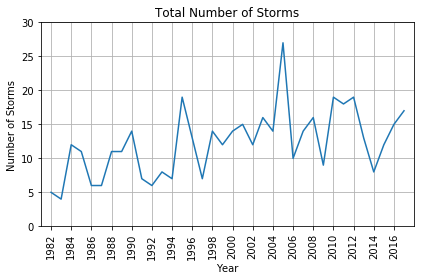

In [18]:
# Separate max windspeed, pressure and category data by year and get the average
grouped = clean_storm_df.groupby(['Year'])

# Set variables
quantity = grouped['Duration'].count()

# Set year labels
first_year = pd.to_numeric(clean_storm_df['Year'].min())
last_year = pd.to_numeric(clean_storm_df['Year'].max())
x_labels = np.arange(first_year,last_year,2)

# Plot total quantity
quantity_line = plt.plot(quantity)
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title("Total Number of Storms")
plt.ylim(0,30)
plt.xlim(-1,36)
plt.xticks(x_labels,x_labels,rotation='vertical')
plt.grid()
plt.tight_layout()

# Show and save figure
plt.savefig("total_storms.png")
plt.show()

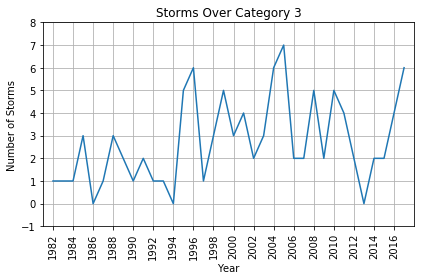

In [19]:
# Create df with counts to ensure no year is left behind
count_df = grouped.count()
# Count storms category 3 or stronger
over3_count = clean_storm_df[clean_storm_df['Category Value'] >= 3].groupby(['Year']).size()
# Add count over 3 to count data frame
count_df['Over 3'] = over3_count
# Replace NaN values with zeros
count_df = count_df.fillna(0)
quantity_over3 = count_df['Over 3']

# Plot total quantity
over3_line = plt.plot(quantity_over3)
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title("Storms Over Category 3")
plt.ylim(-1,8)
plt.xlim(-1,36)
plt.xticks(x_labels,x_labels,rotation='vertical')
plt.grid()
plt.tight_layout()

# Show and save figure
plt.savefig("over3.png")
plt.show()

# Strength of Storms Over the Years

C:\Users\Sofia\Anaconda\envs\PythonData\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


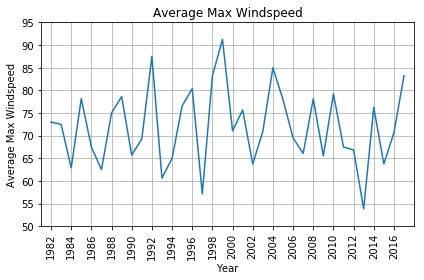

In [20]:
# Create a line graph showing quantity of storms over time
# Separate max windspeed, pressure and category data by year and get the average
strength_df = clean_storm_df[["Year","Max Windspeed","Max Pressure","Duration"]]
strength_df['Duration'] = pd.to_numeric(strength_df['Duration'])
strength_year = strength_df.groupby(['Year'])

# Set variables
max_windspeed_avg = strength_year['Max Windspeed'].mean()
max_pressure_avg = strength_year['Max Pressure'].mean()
duration_avg = strength_year['Duration'].mean()

# Create a line graph showing windspeed of storms over time
# Plot
graph = plt.plot(max_windspeed_avg)
plt.xlabel('Year')
plt.ylabel('Average Max Windspeed')
plt.title("Average Max Windspeed")
plt.ylim(50,95)
plt.xlim(-1,36)
plt.xticks(x_labels,x_labels,rotation='vertical')
plt.grid()
 
plt.tight_layout()
plt.savefig("windspeeds.png")
plt.show()

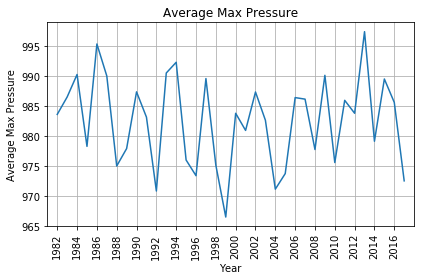

In [21]:
# Create a line graph showing pressure of storms over time
graph = plt.plot(max_pressure_avg)
plt.xlabel('Year')
plt.ylabel('Average Max Pressure')
plt.title("Average Max Pressure")
plt.xlim(-1,36)
plt.xticks(x_labels,x_labels,rotation='vertical')
plt.grid()
 
plt.tight_layout()
plt.savefig("pressures.png")
plt.show()

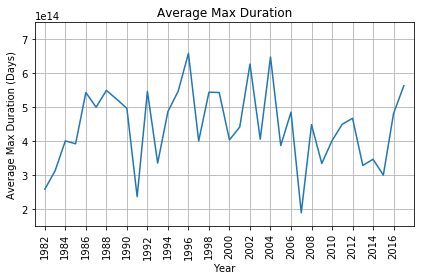

In [22]:
# Create a line graph showing duration of storms over time
# Separate max windspeed data by year and get the average
graph = plt.plot(duration_avg)
plt.xlabel('Year')
plt.ylabel('Average Max Duration (Days)')
plt.title("Average Max Duration")
plt.ylim(150000000000000.56,750000000000000.1)
plt.xlim(-1,36)
plt.xticks(x_labels,x_labels,rotation='vertical')
plt.grid()
 
plt.tight_layout()
plt.savefig("avg_duration.png")
plt.show()

# Most Dangerous Cities in Relationship to Storms

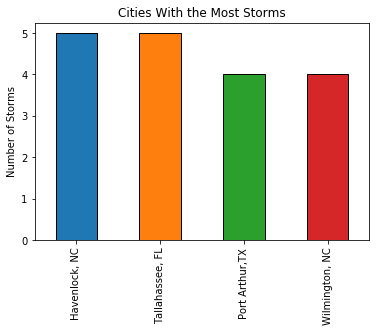

In [23]:
# Bar grapth
# Filter for only cities with 3 storms of more
# Group by cities to get count and avg max winspeed of the storms that hit each city
city_count = clean_storm_df.groupby("Nearest City")['Storm ID'].count()
city_wind = clean_storm_df.groupby("Nearest City")['Max Windspeed'].mean()

# Create data frame
cities_df = pd.DataFrame({"NumberofStorms": city_count,"AvgMaxWindspeed": city_wind})
# Sort to find cities with the most storms
cities_df = cities_df.sort_values('NumberofStorms', ascending =False)
# Keep only cities with 4 storms or more
cities_df = cities_df.loc[cities_df['NumberofStorms'] >= 4,:]

#bar_chart = plt.bar(cities_df.index,cities_df['Number of Storms'])
#bar_chart.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
bar_chart = cities_df.NumberofStorms.plot(kind='bar',ec='black')
plt.xticks(np.arange(0,4,1),('Havenlock, NC','Tallahassee, FL','Port Arthur,TX','Wilmington, NC'), rotation='vertical')
plt.xlabel('')
plt.ylabel('Number of Storms')
plt.title('Cities With the Most Storms')
plt.savefig("top_cities.png", bbox_inches="tight")
plt.show()

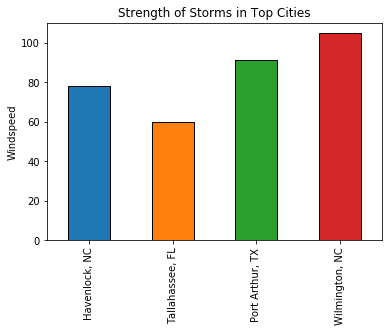

In [24]:
# Bar graph with average strength of storms
# Loop through all cities to search for the average strength of each
#top_cities = cities_df.index
#cities_wind = []

#for city in top_cities:
    #filtered = clean_storm_df.loc[clean_storm_df['Nearest City'] == city,:]
    #city_wind = filtered['Max Windspeed'].mean()
    #cities_wind.append(city_wind)
bar_chart = cities_df.AvgMaxWindspeed.plot(kind='bar',ec='black')
plt.xticks(np.arange(0,4,1),('Havenlock, NC','Tallahassee, FL','Port Arthur, TX','Wilmington, NC'), rotation='vertical')
plt.xlabel('')
plt.ylabel('Windspeed')
plt.title('Strength of Storms in Top Cities')
plt.savefig("top_strength.png", bbox_inches="tight")
plt.show()

# Storm Season

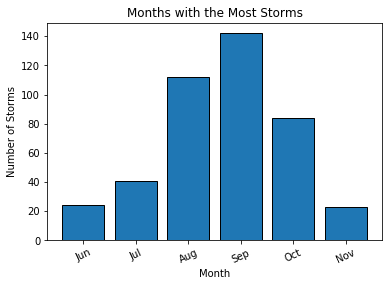

In [25]:
# Get month of each storm
dates = clean_storm_df['Date']
months = dates.dt.month
# Create data frame of storm count in each month
months_df = pd.DataFrame({'Storm Count': months.value_counts()})
months_df = months_df.reset_index().rename(columns={"index":"Month"}).sort_values('Month')
# Filter for storm season (June to November)
storm_season = months_df[(months_df['Month'] >= 6) & (months_df['Month'] <= 11)]
# Plot Results
plt.bar(storm_season['Month'],storm_season['Storm Count'],ec='black')
# Aesthetics
plt.xticks(np.arange(6,12,1),['Jun','Jul','Aug','Sep','Oct','Nov'],rotation=25)
plt.title('Months with the Most Storms')
plt.xlabel('Month')
plt.ylabel('Number of Storms')
plt.savefig("months.png", bbox_inches="tight")
plt.show()

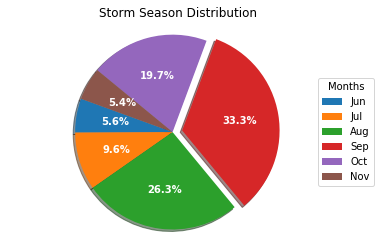

In [26]:
# Pie Graaph showing distribution
labels = ['Jun','Jul','Aug','Sep','Oct','Nov']
sizes =  storm_season['Storm Count']
explode = (0,0,0,.1,0,0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels,explode=explode,autopct ="%1.1f%%",shadow=True,startangle=160,
        textprops=dict(color="w",weight='bold'))
ax1.axis('equal')
plt.legend(title='Months',loc='center right',bbox_to_anchor=(.6, 0, 0.5, 1))
plt.title('Storm Season Distribution')

# Aesthetics
plt.savefig("month_pie.png", bbox_inches="tight")
plt.show()

# Storm Duration

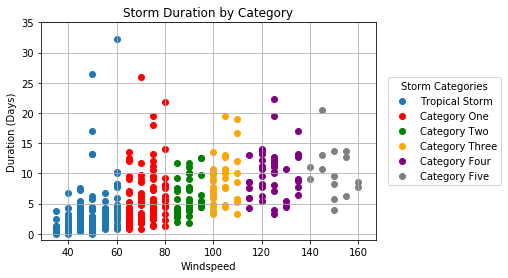

In [27]:
'''How long to storms last on average? Do stronger storms last longer?
	Line graph for duration variance over time. 
Bubble plot with size and color based on category and strenght respectively.'''
# Divide data frame into the different storm categories
tropical_df = clean_storm_df.loc[clean_storm_df['Storm Category'] == 'Tropical Storm',:]
tropical_dur = tropical_df['Duration'] / np.timedelta64(1, 'D')
tropical_wind = tropical_df['Max Windspeed']
Tropical = plt.scatter(tropical_wind,tropical_dur)

one_df = clean_storm_df.loc[clean_storm_df['Storm Category'] == 'Category One',:]
one_dur = one_df['Duration']/ np.timedelta64(1, 'D')
one_wind = one_df['Max Windspeed']
One = plt.scatter(one_wind,one_dur,facecolor='red')

two_df = clean_storm_df.loc[clean_storm_df['Storm Category'] == 'Category Two',:]
two_dur = two_df['Duration']/ np.timedelta64(1, 'D')
two_wind = two_df['Max Windspeed']
Two = plt.scatter(two_wind,two_dur,facecolor='green')

Three_df = clean_storm_df.loc[clean_storm_df['Storm Category'] == 'Category Three',:]
Three_dur = Three_df['Duration']/ np.timedelta64(1, 'D')
Three_wind = Three_df['Max Windspeed']
Three = plt.scatter(Three_wind,Three_dur,facecolor='orange')

Four_df = clean_storm_df.loc[clean_storm_df['Storm Category'] == 'Category Four',:]
Four_dur = Four_df['Duration']/ np.timedelta64(1, 'D')
Four_wind = Four_df['Max Windspeed']
Four = plt.scatter(Four_wind,Four_dur,facecolor='purple')

Five_df = clean_storm_df.loc[clean_storm_df['Storm Category'] == 'Category Five',:]
Five_dur = Five_df['Duration']/ np.timedelta64(1, 'D')
Five_wind = Five_df['Max Windspeed']
Five = plt.scatter(Five_wind,Five_dur,facecolor='grey')

# Aesthetics
lgnd = plt.legend((Tropical, One, Two,Three,Four,Five),
                  ('Tropical Storm','Category One','Category Two','Category Three','Category Four','Category Five'),
           loc='center right',title="Storm Categories",bbox_to_anchor=(.89, 0, 0.5, 1))
plt.xlabel('Windspeed')
plt.ylim(-1,35)
plt.ylabel('Duration (Days)')
plt.title('Storm Duration by Category')
plt.grid()
plt.savefig("scatter.png", bbox_inches="tight")
plt.show()